<a href="https://colab.research.google.com/github/denisecammarota/d2ai-notes/blob/main/ch7_d2ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchinfo import summary

# AlexNet

## Building the AlexNet

In [ ]:
class AlexNet(nn.Module):

  def __init__(self, n_classes = 10):
      super().__init__()
      self.model = nn.Sequential(nn.LazyConv2d(96, kernel_size = 11, stride = 4, padding = 1),
                                 nn.ReLU(), nn.MaxPool2d(kernel_size = 3, stride = 2),
                                 nn.LazyConv2d(256, kernel_size = 5, padding = 2), nn.ReLU(),
                                 nn.MaxPool2d(kernel_size = 3, stride = 2),
                                 nn.LazyConv2d(384, kernel_size = 3, padding = 1), nn.ReLU(),
                                 nn.LazyConv2d(384, kernel_size = 3, padding = 1), nn.ReLU(),
                                 nn.LazyConv2d(256, kernel_size = 3, padding = 1), nn.ReLU(),
                                 nn.MaxPool2d(kernel_size = 3, stride = 2), nn.Flatten(),
                                 nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p = 0.5),
                                 nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p = 0.5),
                                 nn.LazyLinear(n_classes)
                                 )

  def forward(self, x):
    return self.model(x)

## Writing a summary with torchinfo

In [ ]:
model = AlexNet(n_classes=10)
summary(model, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 96, 54, 54]           11,712
│    └─ReLU: 2-2                         [1, 96, 54, 54]           --
│    └─MaxPool2d: 2-3                    [1, 96, 26, 26]           --
│    └─Conv2d: 2-4                       [1, 256, 26, 26]          614,656
│    └─ReLU: 2-5                         [1, 256, 26, 26]          --
│    └─MaxPool2d: 2-6                    [1, 256, 12, 12]          --
│    └─Conv2d: 2-7                       [1, 384, 12, 12]          885,120
│    └─ReLU: 2-8                         [1, 384, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 384, 12, 12]          1,327,488
│    └─ReLU: 2-10                        [1, 384, 12, 12]          --
│    └─Conv2d: 2-11                      [1, 256, 12, 12]       

## Training to classify the Fashion-MNIST data

### Defining device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Loading Fashion-MNIST data as always

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # mean and std for grayscale
])

In [ ]:
train_dataset = datasets.FashionMNIST(
    root=torch.hub.get_dir(),  # uses PyTorch's hub cache directory
    train=True,
    download=True,
    transform=transform
)


test_dataset = datasets.FashionMNIST(
    root=torch.hub.get_dir(),
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 192kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.3MB/s]


In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle=False)

In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
] # labels

In [ ]:
image, label = train_dataset[0] # this is a tuple, so we deconstruct it this way

In [ ]:
image.shape # checking that the size of the image is correct

torch.Size([1, 224, 224])

### Training the AlexNet model

In [ ]:
model = AlexNet(n_classes = 10)
model.to(device)

AlexNet(
  (model): Sequential(
    (0): LazyConv2d(0, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LazyConv2d(0, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): LazyLinear(in_features=0, out_features=4096, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): LazyLinear(in_features=0, out_features=4096, bias=True)
    (

In [ ]:
criterion = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = 0.01)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19


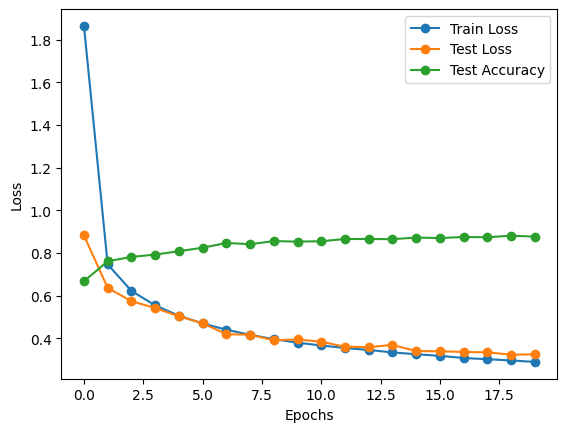

In [ ]:
n_epochs = 20
train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(n_epochs):
  print('Epoch: '+str(epoch))
  train_aux = 0
  test_aux = 0
  test_aux_acc = 0

  # training mode for model
  model.train()
  for batch_X, batch_y in train_loader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    train_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
  train_loss.append(train_aux/len(train_dataset)) # / number of training dataset

  # test mode for model
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)
      output = model(batch_X)
      loss = criterion(output, batch_y)
      predicted_label = output.argmax(dim = 1)
      test_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
      test_aux_acc +=  (predicted_label == batch_y).sum().item()
    test_loss.append(test_aux/len(test_dataset)) # / number of testing dataset
    test_accuracy.append(test_aux_acc/len(test_dataset))


plt.plot(range(n_epochs), train_loss, '-o', label = 'Train Loss')
plt.plot(range(n_epochs), test_loss, '-o', label = 'Test Loss')
plt.plot(range(n_epochs), test_accuracy, '-o', label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VGG (Visual Geometry Group) Blocks

## Defining a VGG block

In [ ]:
def vgg_block(num_convs, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.LazyConv2d(out_channels, kernel_size = 3, padding = 1))
    layers.append(nn.ReLU())
  layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
  return nn.Sequential(*layers)

## Building the VGG network

In [ ]:
class VGG(nn.Module):
  def __init__(self, arch, n_classes = 10):
      super().__init__()
      conv_blocks = []
      for (num_convs, out_channels) in arch:
        conv_blocks.append(vgg_block(num_convs, out_channels))
      self.model = nn.Sequential(
          *conv_blocks,
          nn.Flatten(),
          nn.LazyLinear(4096),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.LazyLinear(4096),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.LazyLinear(n_classes)
      )

  def forward(self, x):
    return self.model(x)

## Writing a summary of out VGG-11 network

In [ ]:
model = VGG(arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)),
            n_classes = 10)

In [ ]:
model.to(device)

VGG(
  (model): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): LazyConv2d(0, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2

In [ ]:
summary(model, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         640
│    │    └─ReLU: 3-2                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-3               [1, 64, 112, 112]         --
│    └─Sequential: 2-2                   [1, 128, 56, 56]          --
│    │    └─Conv2d: 3-4                  [1, 128, 112, 112]        73,856
│    │    └─ReLU: 3-5                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [1, 128, 56, 56]          --
│    └─Sequential: 2-3                   [1, 256, 28, 28]          --
│    │    └─Conv2d: 3-7                  [1, 256, 56, 56]          295,168
│    │    └─ReLU: 3-8                    [1, 256, 56, 56]          --
│    

## Training to classify the Fashion-MNIST dataset

In [ ]:
criterion = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = 0.01)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


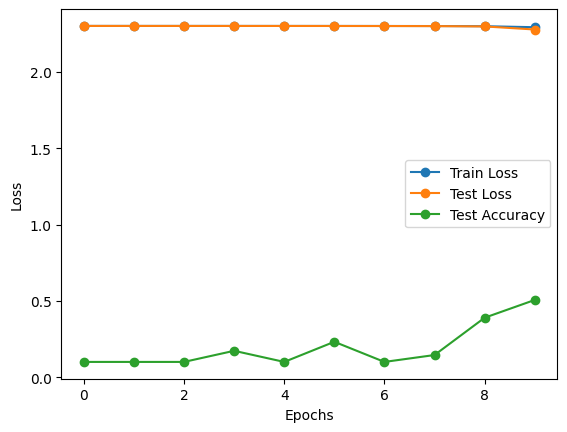

In [ ]:
n_epochs = 10
train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(n_epochs):
  print('Epoch: '+str(epoch))
  train_aux = 0
  test_aux = 0
  test_aux_acc = 0

  # training mode for model
  model.train()
  for batch_X, batch_y in train_loader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    train_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
  train_loss.append(train_aux/len(train_dataset)) # / number of training dataset

  # test mode for model
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)
      output = model(batch_X)
      loss = criterion(output, batch_y)
      predicted_label = output.argmax(dim = 1)
      test_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
      test_aux_acc +=  (predicted_label == batch_y).sum().item()
    test_loss.append(test_aux/len(test_dataset)) # / number of testing dataset
    test_accuracy.append(test_aux_acc/len(test_dataset))


plt.plot(range(n_epochs), train_loss, '-o', label = 'Train Loss')
plt.plot(range(n_epochs), test_loss, '-o', label = 'Test Loss')
plt.plot(range(n_epochs), test_accuracy, '-o', label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Network in Network (NiN)

## Defining a NiN block

In [ ]:
def nin_block(out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.LazyConv2d(out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size = 1),
      nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size = 1),
      nn.ReLU()
  )

## Building a NiN network

In [ ]:
class NiN(nn.Module):
  def __init__(self, n_classes = 10):
      super().__init__()
      self.model = nn.Sequential(
          nin_block(96, kernel_size = 11, strides = 4, padding = 0),
          nn.MaxPool2d(3, stride = 2),
          nin_block(256, kernel_size = 5, strides = 1, padding = 2),
          nn.MaxPool2d(3, stride = 2),
          nin_block(384, kernel_size = 3, strides = 1, padding = 1),
          nn.MaxPool2d(3, stride = 2),
          nn.Dropout(0.5),
          nin_block(n_classes, kernel_size = 3, strides = 1, padding = 1),
          nn.AdaptiveAvgPool2d((1, 1)),
          nn.Flatten()
      )

  def forward(self, x):
    return self.model(x)

## Writing a summary of out VGG-11 network

In [ ]:
model = NiN(n_classes = 10)
model.to(device)

NiN(
  (model): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU()
      (2): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): LazyConv2d(0, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): LazyConv2d(0, 256, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): LazyConv2d(0, 256, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): LazyConv2d(0, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 384, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): LazyConv2d(0, 384, kern

In [ ]:
summary(model, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
NiN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 96, 54, 54]           --
│    │    └─Conv2d: 3-1                  [1, 96, 54, 54]           11,712
│    │    └─ReLU: 3-2                    [1, 96, 54, 54]           --
│    │    └─Conv2d: 3-3                  [1, 96, 54, 54]           9,312
│    │    └─ReLU: 3-4                    [1, 96, 54, 54]           --
│    │    └─Conv2d: 3-5                  [1, 96, 54, 54]           9,312
│    │    └─ReLU: 3-6                    [1, 96, 54, 54]           --
│    └─MaxPool2d: 2-2                    [1, 96, 26, 26]           --
│    └─Sequential: 2-3                   [1, 256, 26, 26]          --
│    │    └─Conv2d: 3-7                  [1, 256, 26, 26]          614,656
│    │    └─ReLU: 3-8                    [1, 256, 26, 26]          --


In [ ]:
def init_cnn(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_cnn)

NameError: name 'model' is not defined

## Training to classify the Fashion-MNIST dataset

In [ ]:
criterion = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = 0.01)

Epoch: 0
0.3543909788131714
0.863
Epoch: 1
0.23139581084251404
0.8677
Epoch: 2
0.24672135710716248
0.8702
Epoch: 3
0.2568555176258087
0.8742
Epoch: 4
0.2667608857154846
0.8782
Epoch: 5
0.29640141129493713
0.8801
Epoch: 6
0.30141642689704895
0.8825
Epoch: 7
0.32757455110549927
0.8821
Epoch: 8
0.24388769268989563
0.8893
Epoch: 9
0.3223266005516052
0.8884


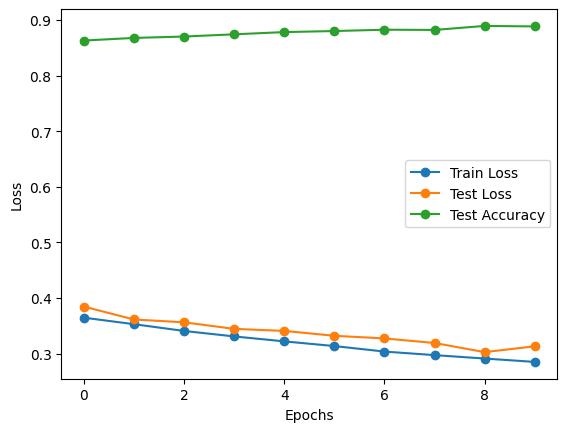

In [ ]:
n_epochs = 10
train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(n_epochs):
  print('Epoch: '+str(epoch))
  train_aux = 0
  test_aux = 0
  test_aux_acc = 0

  # training mode for model
  model.train()
  for batch_X, batch_y in train_loader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    train_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
  train_loss.append(train_aux/len(train_dataset)) # / number of training dataset

  # test mode for model
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)
      output = model(batch_X)
      loss = criterion(output, batch_y)
      predicted_label = output.argmax(dim = 1)
      test_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
      test_aux_acc +=  (predicted_label == batch_y).sum().item()
    test_loss.append(test_aux/len(test_dataset)) # / number of testing dataset
    test_accuracy.append(test_aux_acc/len(test_dataset))
  #print(loss.item())
  print(test_aux_acc/len(test_dataset))

plt.plot(range(n_epochs), train_loss, '-o', label = 'Train Loss')
plt.plot(range(n_epochs), test_loss, '-o', label = 'Test Loss')
plt.plot(range(n_epochs), test_accuracy, '-o', label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# GoogLeNet

## Defining an inception block

In [ ]:
class Inception(nn.Module):

  def __init__(self, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs):
    self.b1_1 = nn.LazyConv2d(c1, kernel_size = 1)
    self.b2_1 = nn.LazyConv2d(c2[0], kernel_size = 1)
    self.b2_2 = nn.LazyConv2d(c2[1], kernel_size = 3, padding = 1)
    self.b3_1 = nn.LazyConv2d(c3[0], kernel_size = 1)
    self.b3_2 = nn.LazyConv2d(c3[1], kernel_size = 5)
    self.b4_1 = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
    self.b4_2 = nn.LazyConv2d(c4, kernel_size = 1)

  def forward(self, x):
    b1 = F.relu(self.b1_1(x))
    b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
    b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
    b4 = F.relu(self.b4_2(self.b4_1(x)))
    return torch.cat((b1, b2, b3, b4), dim = 1)


## Building the GoogLeNet network

In [ ]:
class GoogleNet(nn.Module):

  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size = 7, stride = 2, padding = 3),
        nn.ReLU(), nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    )

    def b2(self):
      return nn.Sequential(
          nn.LazyConv2d(64, kernel_size = 1),
          nn.ReLU(),
          nn.LazyConv2d(192, kernel_size = 3, padding = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
      )

    def b3(self):
      return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                           Inception(128, (128, 192), (32, 96), 64),
                           nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

    def b4(self):
      return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                           Inception(160, (112, 224), (24, 64), 64),
                           Inception(128, (128, 256), (24, 64), 64),
                           Inception(112, (144, 288), (32, 64), 64),
                           Inception(256, (160, 320), (32, 128), 128),
                           nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
    def b5(self):
      return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                           nn.AdaptativeAvgPool2d(1,1), nn.Flatten())

    def __init__(self, n_classes = 10):
      super(GoogleNet, self).__init__()
      self.model = nn.Sequential(self.b1(), self.b2(), self.b3(),
                                 self.b4(). self.b5(), nn.LazyLinear(n_classes))

    def forward(self):
      return self.model(x)

## Writing a summary of out GoogLeNet network

In [ ]:
model = GoogleNet(n_classes = 10)
model.to(device)

In [ ]:
summary(model, input_size=(1, 1, 224, 224))

## Training to classify the Fashion-MNIST dataset

In [ ]:
criterion = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = 0.1)

In [ ]:
n_epochs = 10
train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(n_epochs):
  print('Epoch: '+str(epoch))
  train_aux = 0
  test_aux = 0
  test_aux_acc = 0

  # training mode for model
  model.train()
  for batch_X, batch_y in train_loader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    train_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
  train_loss.append(train_aux/len(train_dataset)) # / number of training dataset

  # test mode for model
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)
      output = model(batch_X)
      loss = criterion(output, batch_y)
      predicted_label = output.argmax(dim = 1)
      test_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
      test_aux_acc +=  (predicted_label == batch_y).sum().item()
    test_loss.append(test_aux/len(test_dataset)) # / number of testing dataset
    test_accuracy.append(test_aux_acc/len(test_dataset))


plt.plot(range(n_epochs), train_loss, '-o', label = 'Train Loss')
plt.plot(range(n_epochs), test_loss, '-o', label = 'Test Loss')
plt.plot(range(n_epochs), test_accuracy, '-o', label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# LeNet with batch normalization

## Building the LeNet + Batch normalization network

In [ ]:
class BNLeNet(nn.Module):

  def __init__(self, n_classes):
      super().__init__()
      self.model = nn.Sequential(nn.LazyConv2d(6, kernel_size = 5),
                                 nn.LazyBatchNorm2d(),
                                 nn.Sigmoid(),
                                 nn.AvgPool2d(kernel_size = 2, stride = 2),
                                 nn.LazyConv2d(16, kernel_size = 5),
                                 nn.LazyBatchNorm2d(),
                                 nn.Sigmoid(),
                                 nn.AvgPool2d(kernel_size = 2, stride = 2),
                                 nn.Flatten(),
                                 nn.LazyLinear(120),
                                 nn.LazyBatchNorm1d(),
                                 nn.Sigmoid(),
                                 nn.LazyLinear(84),
                                 nn.LazyBatchNorm1d(),
                                 nn.Sigmoid(),
                                nn.LazyLinear(out_features = n_classes))

  def forward(self, x):
    return self.model(x)

## Writing a summary of our LeNet + Batch normalization network

In [ ]:
model = BNLeNet(n_classes = 10)
model.to(device)

BNLeNet(
  (model): Sequential(
    (0): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Sigmoid()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): LazyLinear(in_features=0, out_features=120, bias=True)
    (10): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
    (12): LazyLinear(in_features=0, out_features=84, bias=True)
    (13): LazyBatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Sigmoid()
    (15): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)

In [ ]:
summary(model, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
BNLeNet                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 6, 220, 220]          156
│    └─BatchNorm2d: 2-2                  [1, 6, 220, 220]          12
│    └─Sigmoid: 2-3                      [1, 6, 220, 220]          --
│    └─AvgPool2d: 2-4                    [1, 6, 110, 110]          --
│    └─Conv2d: 2-5                       [1, 16, 106, 106]         2,416
│    └─BatchNorm2d: 2-6                  [1, 16, 106, 106]         32
│    └─Sigmoid: 2-7                      [1, 16, 106, 106]         --
│    └─AvgPool2d: 2-8                    [1, 16, 53, 53]           --
│    └─Flatten: 2-9                      [1, 44944]                --
│    └─Linear: 2-10                      [1, 120]                  5,393,400
│    └─BatchNorm1d: 2-11                 [1, 120]                  240
│  

## Training to classify the Fashion-MNIST dataset

In [ ]:
criterion = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = 0.1)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


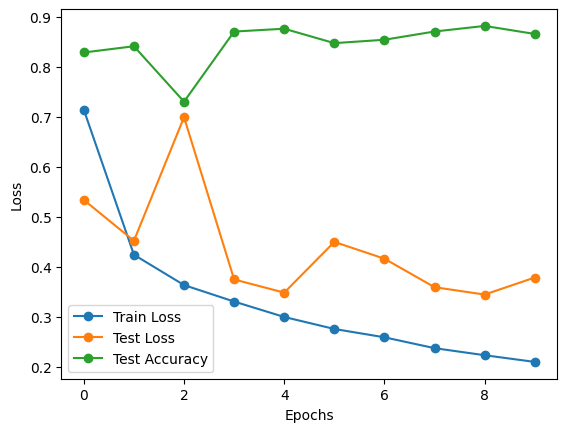

In [ ]:
n_epochs = 10
train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(n_epochs):
  print('Epoch: '+str(epoch))
  train_aux = 0
  test_aux = 0
  test_aux_acc = 0

  # training mode for model
  model.train()
  for batch_X, batch_y in train_loader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    train_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
  train_loss.append(train_aux/len(train_dataset)) # / number of training dataset

  # test mode for model
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)
      output = model(batch_X)
      loss = criterion(output, batch_y)
      predicted_label = output.argmax(dim = 1)
      test_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
      test_aux_acc +=  (predicted_label == batch_y).sum().item()
    test_loss.append(test_aux/len(test_dataset)) # / number of testing dataset
    test_accuracy.append(test_aux_acc/len(test_dataset))


plt.plot(range(n_epochs), train_loss, '-o', label = 'Train Loss')
plt.plot(range(n_epochs), test_loss, '-o', label = 'Test Loss')
plt.plot(range(n_epochs), test_accuracy, '-o', label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ResNet and ResNeXt

## Building the ResNet network

### Creating a Residual block

In [ ]:
class Residual(nn.Module):

  def __init__(self, num_channels, use_1x1conv = False, strides = 1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size = 3, padding = 1, stride = strides)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size = 3, padding = 1)
    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size = 1, stride = strides)
    else:
      self.conv3 = None
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()


  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

### Using the Residual Block

In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [ ]:
blk = Residual(6, use_1x1conv = True, strides = 2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### Building the ResNet itself

In [ ]:
class ResNet(nn.Module):

  def b1(self): # the GoogLeNet part
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size = 7, stride = 2, padding = 3),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    )

  def block(self, num_residuals, num_channels, first_block = False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        blk.append(Residual(num_channels, use_1x1conv = True, strides = 2))
      else:
        blk.append(Residual(num_channels))
      return nn.Sequential(*blk)

  def __init__(self, arch, lr = 0.1, num_classes = 10):
    super().__init__()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
      self.net.add_module(f'b{i+2}', self.block(*b, first_block = (i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)
    ))

  def forward(self, x):
    return self.net(x)

In [ ]:
class ResNet18(ResNet):
  def __init__(self, lr = 0.1, num_classes = 10):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)


In [ ]:
model = ResNet18(lr=0.01)
model.to(device)

ResNet18(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (b3): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (conv2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): LazyC

In [ ]:
summary(model, input_size=(1, 1, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-1                  [1, 64, 48, 48]           3,200
│    │    └─BatchNorm2d: 3-2             [1, 64, 48, 48]           128
│    │    └─ReLU: 3-3                    [1, 64, 48, 48]           --
│    │    └─MaxPool2d: 3-4               [1, 64, 24, 24]           --
│    └─Sequential: 2-2                   [1, 64, 24, 24]           --
│    │    └─Residual: 3-5                [1, 64, 24, 24]           74,112
│    └─Sequential: 2-3                   [1, 128, 12, 12]          --
│    │    └─Residual: 3-6                [1, 128, 12, 12]          230,272
│    └─Sequential: 2-4                   [1, 256, 6, 6]            --
│    │    └─Residual: 3-7                [1, 256, 6, 6]            919,2

### Training to classify the Fashion-MNIST dataset

In [ ]:
model = ResNet18(lr=0.01)
model.to(device)

ResNet18(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (b3): Sequential(
      (0): Residual(
        (conv1): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (conv2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): LazyC

In [ ]:
def init_resnet_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(
            m.weight, mode="fan_out", nonlinearity="relu"
        )
        if m.bias is not None:
            nn.init.zeros_(m.bias)

    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [ ]:
_ = model(torch.zeros(1, 1, 224, 224, device=device))

In [ ]:
model.apply(init_resnet_weights)

ResNet18(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (b2): Sequential(
      (0): Residual(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (b3): Sequential(
      (0): Residual(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(64, 128, kernel_size=(

In [ ]:
criterion = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = 0.1)

Epoch: 0
0.8153
Epoch: 1
0.8652
Epoch: 2
0.8654
Epoch: 3
0.8578
Epoch: 4
0.9104
Epoch: 5
0.9136
Epoch: 6
0.9018
Epoch: 7
0.9122
Epoch: 8
0.9133
Epoch: 9
0.906


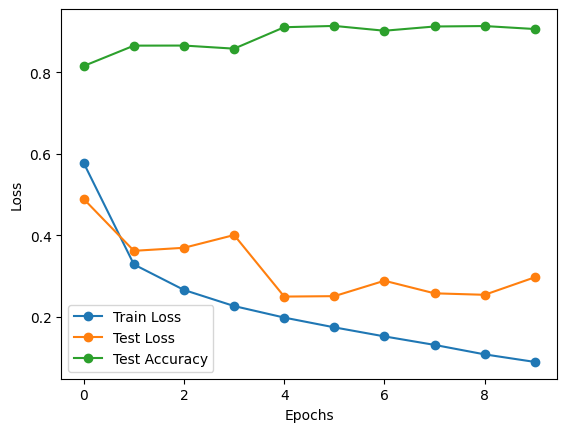

In [ ]:
n_epochs = 10
train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(n_epochs):
  print('Epoch: '+str(epoch))
  train_aux = 0
  test_aux = 0
  test_aux_acc = 0

  # training mode for model
  model.train()
  for batch_X, batch_y in train_loader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    train_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
  train_loss.append(train_aux/len(train_dataset)) # / number of training dataset

  # test mode for model
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)
      output = model(batch_X)
      loss = criterion(output, batch_y)
      predicted_label = output.argmax(dim = 1)
      test_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
      test_aux_acc +=  (predicted_label == batch_y).sum().item()
    test_loss.append(test_aux/len(test_dataset)) # / number of testing dataset
    test_accuracy.append(test_aux_acc/len(test_dataset))
    print(test_aux_acc/len(test_dataset))

plt.plot(range(n_epochs), train_loss, '-o', label = 'Train Loss')
plt.plot(range(n_epochs), test_loss, '-o', label = 'Test Loss')
plt.plot(range(n_epochs), test_accuracy, '-o', label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# DenseNet (Densely Connected Neural Networks)

## Building the DenseNet

### Building dense blocks for concatenation

In [ ]:
def conv_block(num_channels):
  return nn.Sequential(
      nn.LazyBatchNorm2d(), nn.ReLU(),
      nn.LazyConv2d(num_channels, kernel_size = 3, padding = 1))

In [ ]:
class DenseBlock(nn.Module):

  def __init__(self, num_convs, num_channels):
    super().__init__()
    layer = []
    for i in range(num_convs):
      layer.append(conv_block(num_channels))
    self.net = nn.Sequential(*layer)

  def forward(self, X):
    for blk in self.net:
      Y = blk(X)
      X = torch.cat((X, Y), dim = 1)
    return X

In [ ]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### Building transition layers for reducing channel number

In [ ]:
def transition_block(num_channels):
  return nn.Sequential(
      nn.LazyBatchNorm2d(), nn.ReLU(),
      nn.LazyConv2d(num_channels, kernel_size = 1),
      nn.AvgPool2d(kernel_size = 2, stride = 2)
  )

In [ ]:
blk = transition_block(10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### DenseNet model per se

In [ ]:
class DenseNet(nn.Module):

  def b1(self): # initial part of the ResNet
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size = 7, stride = 2, padding = 3),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    )

  def __init__(self, num_channels = 64, growth_rate = 32, arch = (4, 4, 4, 4), lr = 0.1, num_classes = 10):
    super().__init__()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
      self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, growth_rate))
      num_channels += num_convs*growth_rate
      if i != len(arch) - 1:
        num_channels //= 2
        self.net.add_module(f'tran_blk{i+1}', transition_block(num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)
    ))

  def forward(self, x):
    return self.net(x)

### Adjusting the input images to 96*96

In [ ]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # mean and std for grayscale
])

train_dataset = datasets.FashionMNIST(
    root=torch.hub.get_dir(),  # uses PyTorch's hub cache directory
    train=True,
    download=True,
    transform=transform
)


test_dataset = datasets.FashionMNIST(
    root=torch.hub.get_dir(),
    train=False,
    download=True,
    transform=transform
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle=False)

### Training DenseNet

In [ ]:
model = DenseNet(lr=0.01)
model.to(device)

DenseNet(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (dense_blk1): DenseBlock(
      (net): Sequential(
        (0): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [ ]:
_ = model(torch.zeros(1, 1, 96, 96, device=device))
model.apply(init_resnet_weights)

DenseNet(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (dense_blk1): DenseBlock(
      (net): Sequential(
        (0): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): Sequential(
          (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
       

In [ ]:
criterion = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.SGD(model.parameters(), lr = 0.1)

Epoch: 0
0.8341
Epoch: 1
0.771
Epoch: 2
0.8832
Epoch: 3
0.8722
Epoch: 4
0.9012
Epoch: 5
0.8855
Epoch: 6
0.9136
Epoch: 7
0.911
Epoch: 8
0.9014
Epoch: 9
0.9085


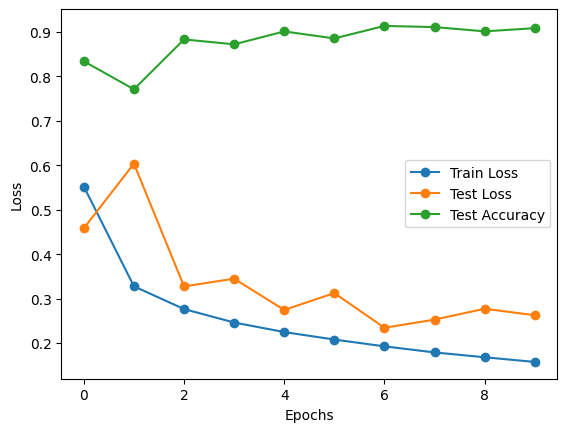

In [ ]:
n_epochs = 10
train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(n_epochs):
  print('Epoch: '+str(epoch))
  train_aux = 0
  test_aux = 0
  test_aux_acc = 0

  # training mode for model
  model.train()
  for batch_X, batch_y in train_loader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()
    output = model(batch_X)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
    train_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
  train_loss.append(train_aux/len(train_dataset)) # / number of training dataset

  # test mode for model
  model.eval()
  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)
      output = model(batch_X)
      loss = criterion(output, batch_y)
      predicted_label = output.argmax(dim = 1)
      test_aux += loss.item() * len(batch_X) # * 128 (batch_size, except for the last batch maybe)
      test_aux_acc +=  (predicted_label == batch_y).sum().item()
    test_loss.append(test_aux/len(test_dataset)) # / number of testing dataset
    test_accuracy.append(test_aux_acc/len(test_dataset))
    print(test_aux_acc/len(test_dataset))

plt.plot(range(n_epochs), train_loss, '-o', label = 'Train Loss')
plt.plot(range(n_epochs), test_loss, '-o', label = 'Test Loss')
plt.plot(range(n_epochs), test_accuracy, '-o', label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()